In [2]:
!pip install qiskit_nature
!pip install qutip
!pip install qiskit
!pip install pylatexenc

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(0)

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pylab
from typing import List 
import qutip as qt
from tqdm import tqdm
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import GroundStateEigensolver,NumPyMinimumEigensolverFactory
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper

from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP,SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import I, X, Z, Y
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister 

from numbers import Number

from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister 


from qiskit.extensions.unitary import UnitaryGate

def energy_solver(operator):
    npme = NumPyMinimumEigensolver()
    result = npme.compute_minimum_eigenvalue(operator=operator)
    return result.eigenvalue.real

# Machine learning with VQE 
## First, we will make the train data. It is a two-parameter gaussian distribution. As the train sets, we prepare the pdf whose mean are (0.0, 0.5) and (0.7,0.2)

In [4]:
def pdf_array(mu_x,mu_y,sigma_x,sigma_y, rho):
    # Average
    mus = np.array([mu_x, mu_y])
    # Variance-Covariance matrix
    sigmas = np.array([[sigma_x**2, rho*sigma_x*sigma_y], [rho*sigma_x*sigma_y, sigma_y**2]])
    x = np.arange(0, 1.0, 0.01)
    y = np.arange(0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    Z = stats.multivariate_normal.pdf(pos, mean=mus, cov=sigmas)
    return Z

<Figure size 432x288 with 0 Axes>

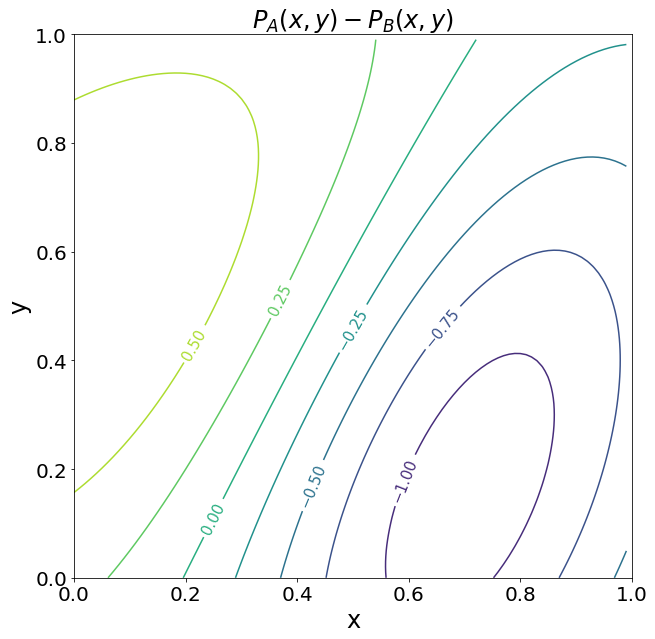

<Figure size 432x288 with 0 Axes>

In [5]:
x = np.arange(0, 1.0, 0.01)
y = np.arange(0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
Z1 = pdf_array(0.0,0.5,0.5,0.5,0.5)
Z2 = pdf_array(0.7,0.2,0.3,0.5,0.5)

fig, ax = plt.subplots(figsize=(10, 10))
cntr = ax.contour(X, Y, Z1-Z2)
#cntr = ax.contour(X, Y, Z2)

ax.clabel(cntr, fontsize=15)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x",fontsize=24)
plt.ylabel("y",fontsize=24)
plt.title("$P_A(x,y)-P_B(x,y)$",fontsize=24)
plt.figure()

## Two distributions are equal at $P_A(x,y)=P_B(x,y)$, which is shown with "0.00" line. Finding this optimal separation is our goal.

## Using the conditional probabilities, we perform Gibbs sampling to obtain the train data.

In [6]:
# p(x|y)
def px_cond_y(y, mu_x,mu_y,sigma_x,sigma_y, rho):
    px_mean = mu_x + rho*(sigma_x/sigma_y)*(y-mu_y)
    px_scale = sigma_x*np.sqrt(1-rho**2)
    return np.random.normal(loc=px_mean, scale=px_scale)    

# p(y|x)
def py_cond_x(x,mu_x,mu_y,sigma_x,sigma_y, rho):
    py_mean = mu_y + rho*(sigma_y/sigma_x)*(x-mu_x)
    py_scale = sigma_y*np.sqrt(1-rho**2)
    return np.random.normal(loc=py_mean, scale=py_scale)

def gibbs_sampling(mu_x,mu_y,sigma_x,sigma_y, rho):
    '''Gibbs Sampling

    Parameters
    steps : Monte-Carlo step
    x_init : Initial position

    Return
    samples : Results from the Gibbs sampling
    '''
    steps=500
    x_init=[0,0]
    samples = []
    x, y = x_init[0], x_init[1]

    for i in range(steps):
        x = px_cond_y(y,mu_x,mu_y,sigma_x,sigma_y, rho)
        samples.append([x, y])
        y = py_cond_x(x,mu_x,mu_y,sigma_x,sigma_y, rho)
        samples.append([x, y])
        
    return np.array(samples)

Load the train data

In [7]:
dataA = np.load("datasetA.npy", allow_pickle = True)
dataB = np.load("datasetB.npy", allow_pickle = True)
print(len(dataA))
print(len(dataB))

323
485


Data with the label 0

In [8]:
dataA[0]

array([array([0.45895579, 0.        ]), 0], dtype=object)

Data with label 1

In [9]:
dataB[0]

array([array([0.87231379, 0.36903929]), 1], dtype=object)

In [10]:
from qiskit.opflow import I, X, Z

Perform the featuremap that is discussed in the main text.

In [11]:
def feature_map(sample):
    op1= I + np.sin(np.pi*sample[0][0])*X + np.cos(np.pi*sample[0][0])*Z
    op2= I + np.sin(np.pi*sample[0][1])*X + np.cos(np.pi*sample[0][1])*Z
    op3 = (1- sample[1]) * Z + sample[1] *X
    return -0.125*((op1^op2))^op3

Construct the Hamiltonian that is defined in the main text.

In [12]:
train_op = 0.0*I^I^I
for i in range(100):
    train_op += feature_map(dataA[i+1])
    train_op += feature_map(dataB[i+1])

In [13]:
train_op = train_op.reduce()

In [14]:
train_op

PauliSumOp(SparsePauliOp(['IIZ', 'IXZ', 'IZZ', 'XIZ', 'XXZ', 'XZZ', 'ZIZ', 'ZXZ', 'ZZZ', 'IIX', 'IXX', 'IZX', 'XIX', 'XXX', 'XZX', 'ZIX', 'ZXX', 'ZZX'],
              coeffs=[-12.5       +0.j,  -8.6704597 +0.j,   2.49044244+0.j,  -8.64093149+0.j,
  -6.01302201+0.j,   1.63403758+0.j,  -5.54995513+0.j,  -3.82907498+0.j,
   0.63315251+0.j, -12.5       +0.j,  -8.06289559+0.j,  -4.17596788+0.j,
  -8.83728529+0.j,  -5.73209279+0.j,  -3.45028409+0.j,   5.01519284+0.j,
   3.44652406+0.j,   0.58246645+0.j]), coeff=1.0)

# VQE PART

In [15]:
seed = 175
iterations = 125
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,shots=8192) 

In [16]:
train_op

PauliSumOp(SparsePauliOp(['IIZ', 'IXZ', 'IZZ', 'XIZ', 'XXZ', 'XZZ', 'ZIZ', 'ZXZ', 'ZZZ', 'IIX', 'IXX', 'IZX', 'XIX', 'XXX', 'XZX', 'ZIX', 'ZXX', 'ZZX'],
              coeffs=[-12.5       +0.j,  -8.6704597 +0.j,   2.49044244+0.j,  -8.64093149+0.j,
  -6.01302201+0.j,   1.63403758+0.j,  -5.54995513+0.j,  -3.82907498+0.j,
   0.63315251+0.j, -12.5       +0.j,  -8.06289559+0.j,  -4.17596788+0.j,
  -8.83728529+0.j,  -5.73209279+0.j,  -3.45028409+0.j,   5.01519284+0.j,
   3.44652406+0.j,   0.58246645+0.j]), coeff=1.0)

Get the reference value

In [17]:
print(f'Number of qubits: {train_op.num_qubits}')
ref_value = energy_solver(train_op)
print(f'Bonding energy value: {ref_value:.5f}')

Number of qubits: 3
Bonding energy value: -53.94358


## Definitions of the analogue blocks that consists of XX, YY, and ZZ interactions

In [18]:
from numbers import Number
import numpy

from qiskit.circuit import Gate, QuantumCircuit, QuantumRegister, ParameterExpression
from qiskit.quantum_info.operators.predicates import matrix_equal
from qiskit.quantum_info.operators.predicates import is_hermitian_matrix
from qiskit.extensions.exceptions import ExtensionError
from qiskit.circuit.exceptions import CircuitError

from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ParameterVector


from qiskit.extensions.unitary import UnitaryGate

# This code is based on https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/extensions/hamiltonian_gate.py licenced under Apache licence.
class CustomHamiltonianGate(Gate):
    def __init__(self, time, num_qubits, connectivity, h_coeffs, label=None):
        if isinstance(time, Number) and time != numpy.real(time):
            raise ExtensionError("Evolution time is not real.")
       
        self.num_qubits = num_qubits
        self.connectivity = connectivity
        self.h_coeff1 = h_coeffs[0]
        self.h_coeff2 = h_coeffs[1]
        self.h_coeff3 = h_coeffs[2]
        # Store instruction params
        super().__init__("custom_hamiltonian", num_qubits, [time, num_qubits, connectivity, h_coeffs[0], h_coeffs[1], h_coeffs[2]], label=label)
        # note that params[0] is time, params[1] is num_qubits, params[2] is connectivity
        # params[3] is h_coeff1, params[4] is h_coeff2, params[5] is h_coeff3

    def __array__(self, dtype=None):
        """Return matrix for the unitary."""
        # pylint: disable=unused-argument
        import scipy.linalg

        try:
            return scipy.linalg.expm(-1j * self.get_ham() * float(self.params[0]))
        except TypeError as ex:
            raise TypeError(
                "Unable to generate Unitary matrix for "
                "unbound t parameter {}".format(self.params[1])
            ) from ex

    def _define(self):
        """Calculate a subcircuit that implements this unitary."""
        q = QuantumRegister(self.num_qubits, "q")
        qc = QuantumCircuit(q, name=self.name)
        qc._append(UnitaryGate(self.to_matrix()), q[:], [])
        self.definition = qc

    def validate_parameter(self, parameter):
        return parameter

    def get_ham(self):
        dim = 2 ** self.num_qubits
        num_connections = len(self.connectivity)
        zz_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)
        xx_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)   # modification to add sigma_x interactions
        yy_hamiltonian = np.zeros([dim, dim], dtype=np.complex128)   # modification to add sigma_y interactions

        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmaz()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmaz()
            zz_hamiltonian += float(self.params[3]) * np.array(qt.tensor(ops_to_tensor)) #+= 
        # repeat for xx and yy interaction hamiltonian. Note that we will change the params[] index    
        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmax()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmax()
            xx_hamiltonian += float(self.params[4]) * np.array(qt.tensor(ops_to_tensor)) 
        for c in range(num_connections):
            ops_to_tensor = [qt.identity(2)] * self.num_qubits
            ops_to_tensor[self.connectivity[c][0]] = qt.sigmay()
            ops_to_tensor[self.connectivity[c][1]] = qt.sigmay()
            yy_hamiltonian += float(self.params[5]) * np.array(qt.tensor(ops_to_tensor)) 
            # now assemble the full hamiltonian
        hamiltonian = zz_hamiltonian + xx_hamiltonian + yy_hamiltonian    
        return hamiltonian

def custom_hamiltonian(self, time, connectivity, h_coeffs, qubits, label=None):
    """Apply hamiltonian evolution to qubits."""
    if not isinstance(qubits, list):
        qubits = [qubits]

    return self.append(CustomHamiltonianGate(time=time, num_qubits=len(qubits), connectivity=connectivity, h_coeffs = h_coeffs, label=label), qubits, [])


QuantumCircuit.custom_hamiltonian = custom_hamiltonian

## Digital-analog Ansatz
Define the function that automatically construct the ansatz that is suited for the given operator. The entanglement has two options: 

staggered: two-body time-evolving operators on i-th and (i+1)-th qubits (for i=0 to n-2)
entire: $n$ body time-evolving operators on the all qubits.

In [19]:
def digital_analog_ansatz(Operator, entanglement = "entire"):
    # First we need to define variational parameters (at least one) phi[...]
    n_qubits = Operator.num_qubits
    phi = ParameterVector("$\phi$", 4 * n_qubits)
    
    if entanglement == "entire":
        t = Parameter("t")
        psi = ParameterVector("$\psi$",3)
        connectivity_arr = []
        qubits_arr = [0]
        for i in range(n_qubits - 1):
            connectivity_arr.append([i, i+1])
            qubits_arr.append(i+1)
    
    if entanglement == "staggered":
        psi = ParameterVector("$\psi$",3*(n_qubits - 1))
        
    # Create a quantum circuit that is used for the ansatz
    ansatz = QuantumCircuit(n_qubits)
    #circuit
    for i in range(n_qubits):
        ansatz.rx(phi[2*i], i)
        ansatz.rz(phi[2*i+1], i)
    if entanglement == "entire":
        ansatz.custom_hamiltonian(connectivity=connectivity_arr, h_coeffs=psi, time=t , qubits=qubits_arr,label='Analog block')
    if entanglement == "staggered":
        for i in range(n_qubits - 1):
            ansatz.custom_hamiltonian(connectivity=[[0, 1]], h_coeffs= psi[3*i:3*i+3], time=1, qubits=[i,i+1], label='$U_{}(t)$'.format(i))
    ##
    for i in range(n_qubits):
        ansatz.rz(phi[2*n_qubits+2*i], i)
        ansatz.rx(phi[2*n_qubits+2*i+1], i)
        
    if entanglement == "entire":
        ansatz.bind_parameters({t: 0.3})
        ansatz.bind_parameters({psi[0]: 0.3})
        ansatz.bind_parameters({psi[1]: 0.3})
        ansatz.bind_parameters({psi[2]: 0.3})
    if entanglement == "staggered":
        for i in range(n_qubits -1):
            ansatz.bind_parameters({psi[i]: 0.3})
    return ansatz

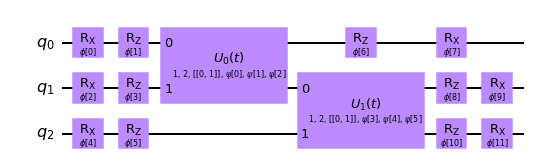

In [20]:
cirq = digital_analog_ansatz(train_op,entanglement = "staggered")
cirq.draw(output="mpl")

In [21]:
def find_E0(Operator, initial_pt, OPTIMIZER = SPSA(maxiter=iterations),entanglement="entire"):
    cirq = digital_analog_ansatz(Operator, entanglement)
    #OPTIMIZER = SLSQP(maxiter=1000) # in the absence of noise we use SLSQP
    #hist-data
    counts = []
    values = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    vqe = VQE(cirq, optimizer=OPTIMIZER, initial_point=initial_pt, callback=store_intermediate_result, quantum_instance=qi, include_custom=True)
    result = vqe.compute_minimum_eigenvalue(operator=Operator)
    hist = (values, counts)
    return result, hist

In [22]:
result, hist = find_E0(train_op, np.random.uniform(low=0.5, high=2.0, size=(18,)),SLSQP(maxiter=1000),entanglement="staggered")

/Users/Atsushi/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/Atsushi/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


## The VQE results
It is close to the reference values -53.94358

In [23]:
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 1485,
    'eigenstate': {   '000': 0.4819749004745994,
                      '001': 0.1690102160373745,
                      '010': 0.4966931664141354,
                      '011': 0.03983608994994363,
                      '100': 0.41751216299648086,
                      '101': 0.3483358876501243,
                      '110': 0.39667194608706574,
                      '111': 0.19452968121857395},
    'eigenvalue': (-53.94357573901705+0j),
    'optimal_parameters': {   ParameterVectorElement($\phi$[2]): 1.341942454884187,
                              ParameterVectorElement($\phi$[5]): 1.8000071735570988,
                              ParameterVectorElement($\phi$[4]): 1.6223801673609441,
                              ParameterVectorElement($\phi$[3]): -0.6624011782018889,
                              ParameterVectorElement($\phi$[7]): 4.123360058241701,
                              ParameterVectorElement($\phi$[0]): 

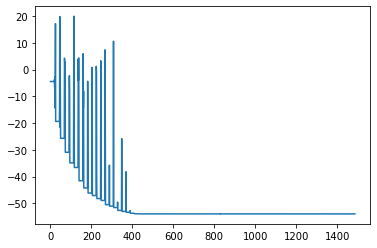

In [24]:
values, counts = hist
plt.plot(counts, values)

## Reconstruct $|\Psi_{GS}\rangle$ from the result

In [25]:
key_list = ['000','001','010','011','100','101','110','111']
result.eigenstate

{'000': 0.4819749004745994,
 '001': 0.1690102160373745,
 '010': 0.4966931664141354,
 '011': 0.03983608994994363,
 '100': 0.41751216299648086,
 '101': 0.3483358876501243,
 '110': 0.39667194608706574,
 '111': 0.19452968121857395}

In [26]:
psi = []
for key in key_list:
  psi.append(result.eigenstate[key])
psi = np.array(psi)

In [27]:
for i in range(8):
    print(i,"\t",i//4,(i//2)%2, i%2, "\t",np.round(psi[i],6))

0 	 0 0 0 	 0.481975
1 	 0 0 1 	 0.16901
2 	 0 1 0 	 0.496693
3 	 0 1 1 	 0.039836
4 	 1 0 0 	 0.417512
5 	 1 0 1 	 0.348336
6 	 1 1 0 	 0.396672
7 	 1 1 1 	 0.19453


In [29]:
np.linalg.norm(psi)

1.0

In [28]:
sigma_z=np.array([[1,0],[0,-1]])
sigma_x=np.array([[0,1],[1,0]])
#<φ(x,y)|ψ_GS> = α|0>+ β|1> = |ψ_out>
def inner_psi(x,y,psi):
    xc = [np.cos(np.pi/2*x),np.sin(np.pi/2*x)]
    yc = [np.cos(np.pi/2*y),np.sin(np.pi/2*y)]
    alpha = 0
    beta = 0
    for i in range(4):
        alpha += psi[2*i]*xc[i//2]*yc[i%2]
        beta += psi[2*i+1]*xc[i//2]*yc[i%2]
    phi = np.array([alpha,beta])
    return phi/np.linalg.norm(phi)

# Check if $|\Psi_{GS}\rangle$ is working as the oracle

In [34]:
x = 0.9
y = 0.8
phi_test = inner_psi(x,y,psi)
z_exp=np.dot(phi_test.T,np.dot(sigma_z,phi_test))
x_exp=np.dot(phi_test.T,np.dot(sigma_x,phi_test))
print("<σz>",z_exp)
print("<σx>",x_exp)
print("Coordinates: ({},{})".format(x,y))
if z_exp > x_exp:
    print("PA")
else:
    print("PB")

<σz> 0.5902882044995014
<σx> 0.8071925641560105
Coordinates: (0.9,0.8)
PB


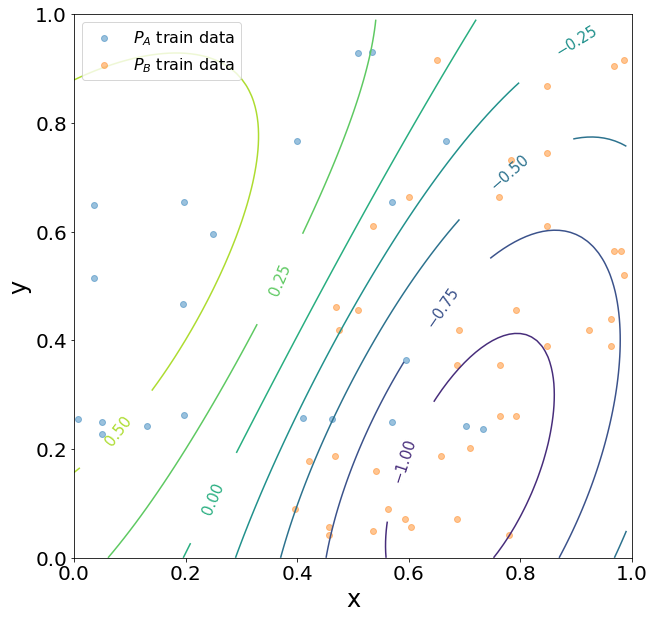

In [35]:
# 初期条件
# ギブスサンプリングの実行
samplesA = gibbs_sampling(0.0,0.5,0.5,0.5,0.5)
samplesB = gibbs_sampling(0.7,0.2,0.3,0.5,0.5)
x = np.arange(0, 1.0, 0.01)
y = np.arange(0, 1.0, 0.01)
X1, Y1 = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(10, 10))
cntr = ax.contour(X1, Y1, Z1-Z2)
#cntr = ax.contour(X, Y, Z2)
ax.scatter(samplesA[1:101, 0], samplesA[1:101, 1], alpha=0.45, c='C0',label="$P_A$ train data")
ax.scatter(samplesB[1:101, 0], samplesB[1:101:, 1], alpha=0.45, c='C1',label="$P_B$ train data")
ax.clabel(cntr, fontsize=15)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x",fontsize=24)
plt.ylabel("y",fontsize=24)
#plt.title("$P_A(x,y)-P_B(x,y)$",fontsize=24)
plt.legend(fontsize=16)

In [36]:
x = np.arange(0, 1.0, 0.001)
y = np.arange(0, 1.0, 0.001)
X1, Y1 = np.meshgrid(x, y)

## Define the classifier that measure $|\psi_{out}\rangle$

In [37]:
def classifier(x,y):
    phi = inner_psi(x,y,psi)
    z_exp=np.dot(phi.T,np.dot(sigma_z,phi))
    x_exp=np.dot(phi.T,np.dot(sigma_x,phi))
    return int(z_exp<x_exp)

In [38]:
classifier(0.6,0.85)

0

## if the point belongs to $P_A$ or $P_B$, 0 or 1 is assigned, respectively.

In [39]:
Prediction = np.zeros((1000,1000))
for i in range(1000):
    for j in range(1000):
        Prediction[i,j] = classifier(X1[i,j], Y1[i,j])

# Plot the boundary of 0 and 1, predicted by the oracle.

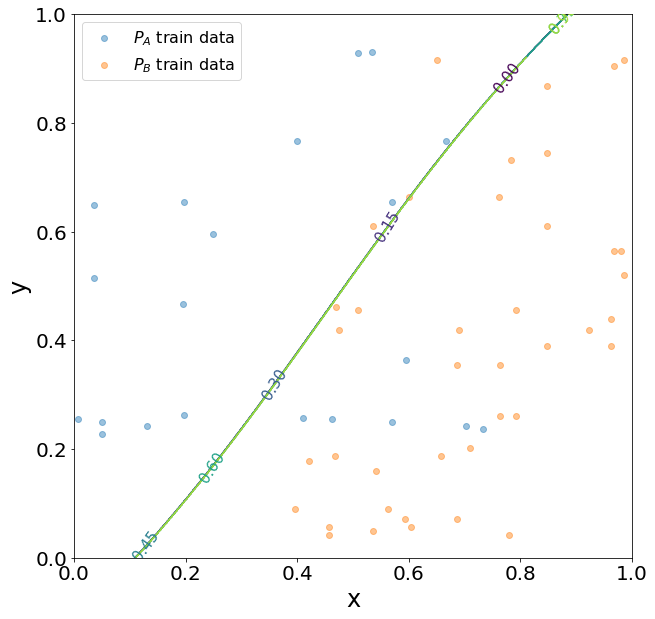

In [40]:
# 初期条件
# ギブスサンプリングの実行

fig, ax = plt.subplots(figsize=(10, 10))
#cntr = ax.contour(X1, Y1, Z1-Z2)
cntr = ax.contour(X1, Y1, Prediction)
ax.scatter(samplesA[1:101, 0], samplesA[1:101, 1], alpha=0.45, c='C0',label="$P_A$ train data")
ax.scatter(samplesB[1:101, 0], samplesB[1:101:, 1], alpha=0.45, c='C1',label="$P_B$ train data")
ax.clabel(cntr, fontsize=15)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("x",fontsize=24)
plt.ylabel("y",fontsize=24)
#plt.title("$P_A(x,y)-P_B(x,y)$",fontsize=24)
plt.legend(fontsize=16)